In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Used to change filepaths
from pathlib import Path
import matplotlib.pyplot as plt
import IPython
from IPython.display import display
from PIL import Image
%matplotlib inline
import os
print(os.listdir("../input"))

from keras.preprocessing.image import img_to_array, array_to_img
from sklearn.metrics import confusion_matrix
import time

['cisc6000-deep-learning-hw2']


In [16]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

In [17]:
image = Image.open('../input/cisc6000-deep-learning-hw2/train_clean_data/image_00000.png') 
print(image.format)
print(image.size)
print(image.mode)

PNG
(64, 64)
RGB


In [18]:
np_img = np.array(image)
print(np_img.shape)

(64, 64, 3)


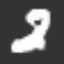

In [19]:
IPython.display.Image(filename='../input/cisc6000-deep-learning-hw2/train_clean_data/image_00000.png') 

In [20]:
#open clean training images
train_clean=[]
for i in os.listdir('../input/cisc6000-deep-learning-hw2/train_clean_data'):
    img = Image.open(os.path.join('../input/cisc6000-deep-learning-hw2/train_clean_data',i)).convert('L')
    train_clean.append(img_to_array(img))
    
x_train=np.array(train_clean)
#x_train=np.expand_dims(x_train,axis=-1)

In [21]:
x_train.shape

(30000, 64, 64, 1)

In [22]:
#open noisy training images
train_noisy=[]
for i in os.listdir('../input/cisc6000-deep-learning-hw2/train_noisy_data'):
    img = Image.open(os.path.join('../input/cisc6000-deep-learning-hw2/train_noisy_data',i)).convert('L')
    train_noisy.append(img_to_array(img))
    
y_train=np.array(train_noisy)
#y_train=np.expand_dims(y_train,axis=-1)

In [23]:
y_train.shape

(30000, 64, 64, 1)

In [24]:
#open clean test images
test_clean=[]
for i in os.listdir('../input/cisc6000-deep-learning-hw2/test_clean_data'):
    img = Image.open(os.path.join('../input/cisc6000-deep-learning-hw2/test_clean_data',i)).convert('L')
    test_clean.append(img_to_array(img))

x_test=np.array(test_clean)
#x_test=np.expand_dims(x_test,axis=-1)

In [25]:
x_test.shape

(20000, 64, 64, 1)

In [26]:
#open noisy test images
test_noisy=[]
for i in os.listdir('../input/cisc6000-deep-learning-hw2/test_noisy_data'):
    img = Image.open(os.path.join('../input/cisc6000-deep-learning-hw2/test_noisy_data',i)).convert('L')
    test_noisy.append(img_to_array(img))

y_test=np.array(test_noisy)
#y_test=np.expand_dims(y_test,axis=-1)

In [27]:
y_test.shape

(20000, 64, 64, 1)

In [28]:
#normalizes the supplied array and reshapes it into the appropriate format.
def preprocess(array):
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 64, 64, 1))
    return array

In [29]:
x_train = preprocess(x_train)
y_train = preprocess(y_train)
x_test = preprocess(x_test)
y_test = preprocess(y_test)

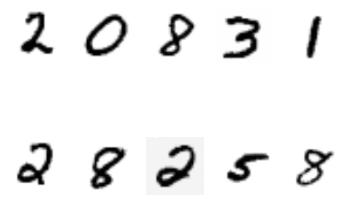

In [30]:
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i],cmap='gray_r')
    plt.subplots_adjust(hspace=0.5)
    plt.axis('off')

In [65]:
#building autoencoder
input = layers.Input(shape=(64,64,1))

#encoder
#input
x = layers.Conv2D(16,(3,3), activation='relu',padding='same',strides=(1,1))(input)
x = layers.MaxPooling2D((2,2),padding='same')(x)
#hidden layers
x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(x)
x = layers.MaxPooling2D(2,2,padding='same')(x)
x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(x)
x = layers.MaxPooling2D(2,2,padding='same')(x)
x = layers.Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)

encoder = Model(input,x)

#decoder
x = layers.Conv2DTranspose(32,(3,3),strides=1,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(24,(3,3),strides=2,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(24,(3,3),strides=2,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(16,(5,5),strides=2,activation='relu',padding='same')(x)
x = layers.Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)

autoencoder = Model(input,x)

In [66]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 16)          0   

In [67]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy'
)

In [68]:
mcp_save = ModelCheckpoint(filepath= 'autoencoder',save_best_only=True,monitor='val_loss',mode='min')
start = time.time()
history = autoencoder.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.25,
    shuffle = True,
    callbacks=[mcp_save]
)
end = time.time()
print(f'Training took {(end-start)} seconds')

Epoch 1/50
176/176 [==============================] - 33s 184ms/step - loss: 0.6395 - val_loss: 0.6189
Epoch 2/50
176/176 [==============================] - 32s 184ms/step - loss: 0.5904 - val_loss: 0.5784
Epoch 3/50
176/176 [==============================] - 32s 183ms/step - loss: 0.5764 - val_loss: 0.5750
Epoch 4/50
176/176 [==============================] - 33s 185ms/step - loss: 0.5747 - val_loss: 0.5739
Epoch 5/50
176/176 [==============================] - 32s 184ms/step - loss: 0.5738 - val_loss: 0.5734
Epoch 6/50
176/176 [==============================] - 33s 190ms/step - loss: 0.5733 - val_loss: 0.5728
Epoch 7/50
176/176 [==============================] - 33s 190ms/step - loss: 0.5729 - val_loss: 0.5725
Epoch 8/50
176/176 [==============================] - 33s 187ms/step - loss: 0.5725 - val_loss: 0.5722
Epoch 9/50
176/176 [==============================] - 33s 187ms/step - loss: 0.5723 - val_loss: 0.5720
Epoch 10/50
176/176 [==============================] - 33s 186ms/step - l

625/625 - 13s - loss: 0.5696


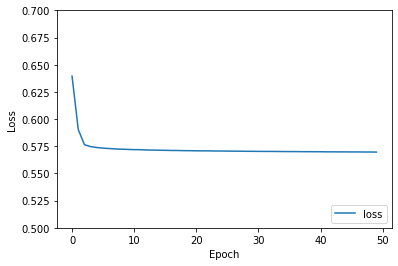

In [69]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 0.7])
plt.legend(loc='lower right')

test_loss = autoencoder.evaluate(x_test, y_test, verbose=2)

In [70]:
denoise = autoencoder.predict(y_test)

In [71]:
latent_vector = encoder.predict(y_test)

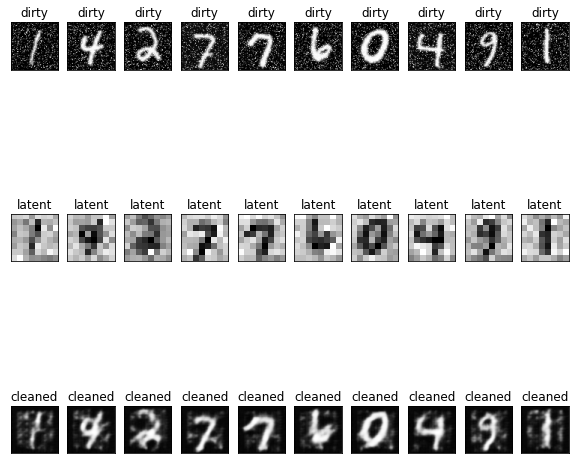

In [72]:
fig = plt.figure(figsize=(10,10))

for i in range(10):
    fig.add_subplot(3,10,i+1)
    plt.imshow(y_test[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('dirty')
    fig.add_subplot(3,10,10+(i+1))
    plt.imshow(latent_vector[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('latent')
    fig.add_subplot(3,10,20+(i+1))
    plt.imshow(denoise[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('cleaned')


In [73]:
m=tf.keras.models.load_model('../input/cisc6000-deep-learning-hw2/M.weights.hdf5')
m.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 31, 64)        1088      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        32800     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 24)          12312     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6, 6, 24)         

In [74]:
test_labels=pd.read_csv('../input/cisc6000-deep-learning-hw2/labels.csv',usecols=[1],index_col=False)
test_labels=test_labels.to_numpy()

In [75]:
y_pred = m.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

#print("Classification Report: \n", classification_report(test_labels, y_pred_classes))

matrix = confusion_matrix(test_labels,y_pred_classes) 
print(matrix.diagonal()/matrix.sum(axis=1))

[0.09670987 0.10293386 0.10580709 0.0959799  0.09984871 0.09448819
 0.09493042 0.09300049 0.12481928 0.09727226]


In [76]:
y_pred = m.predict(y_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

#print("Classification Report: \n", classification_report(test_labels, y_pred_classes))

matrix = confusion_matrix(test_labels,y_pred_classes) 
print(matrix.diagonal()/matrix.sum(axis=1))

[0.08723829 0.         0.05954724 0.05979899 0.09228442 0.04671916
 0.07654076 0.05482134 0.43662651 0.08286155]


In [77]:
denoise_clean = autoencoder.predict(x_test)

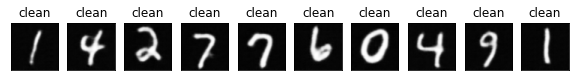

In [78]:
fig = plt.figure(figsize=(10,10))

for i in range(10):
    fig.add_subplot(1,10,i+1)
    plt.imshow(denoise_clean[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('clean')

In [79]:
y_pred = m.predict(denoise_clean)
y_pred_classes = [np.argmax(element) for element in y_pred]

#print("Classification Report: \n", classification_report(test_labels, y_pred_classes))

matrix = confusion_matrix(test_labels,y_pred_classes) 
print(matrix.diagonal()/matrix.sum(axis=1))

[0.09870389 0.10293386 0.1003937  0.08844221 0.09884014 0.08818898
 0.09642147 0.09153206 0.14313253 0.09881626]


In [50]:
#denoise_noisy = autoencoder.predict(y_test)

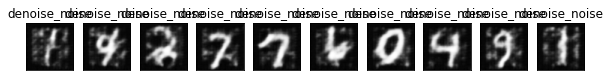

In [80]:
fig = plt.figure(figsize=(10,10))

for i in range(10):
    fig.add_subplot(3,10,i+1)
    plt.imshow(denoise[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('denoise_noise')

In [82]:
y_pred = m.predict(denoise)
y_pred_classes = [np.argmax(element) for element in y_pred]

#print("Classification Report: \n", classification_report(test_labels, y_pred_classes))

matrix = confusion_matrix(test_labels,y_pred_classes) 
print(matrix.diagonal()/matrix.sum(axis=1))

[0.10169492 0.02386872 0.06889764 0.05577889 0.09026727 0.06351706
 0.09294235 0.07440039 0.32626506 0.09418425]
